# Neural Network Optimization and Tuning

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
# from torchvision import MNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2020)

In [15]:

# Fashion Class that enables the Dataset download and basic transformations
# class Fashion(datasets.MNIST):
#     def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
#         self.urls = [
#             'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
#             'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
#             'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
#             'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
#         ]
#         super(Fashion, self).__init__(
#             root, train=train, transform=transform, target_transform=target_transform, download=False
#         ) 

def decode_label(l):
    return ["Top",
     "Trouser",
     "Pullover",
     "Dress",
     "Coat",
     "Sandal",
     "Shirt",
     "Sneaker",
     "Bag",
     "Ankle boot"
    ][l]

In [16]:
trainData = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                            ]))

testData = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                            ]))

# train_data = Fashion('/tmp/data', train=True, download=True, transform=transforms.Compose([
#                                     transforms.ToTensor(),
#                                     transforms.Normalize((0.1307,), (0.3081,))
#                             ]))

# test_data = Fashion('/tmp/data', train=False, download=True, transform=transforms.Compose([
#                                    transforms.ToTensor(),
#                                    transforms.Normalize((0.1307,), (0.3081,))
#                             ]))

/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


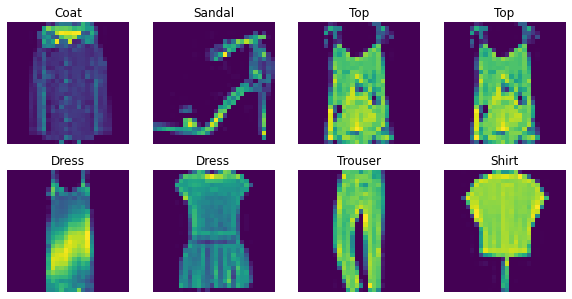

In [17]:
idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = trainData.train_data[idxs[i]]
    Y = trainData.train_labels[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(decode_label(Y))
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
plt.draw()

In [18]:
# Build a model

class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel())
    

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [19]:
trainSize = trainData.train_data.shape[0]
valSize, trainSize = int(0.20 * trainSize), int(0.80 * trainSize) # 80/20 train-val split
testSize = testData.test_data.shape[0]
batchSize = 100

# Add dataset to dataloader that handles batching
trainLoader = torch.utils.data.DataLoader(
    trainData, batch_size=batchSize, 
    sampler=torch.utils.data.sampler.SubsetRandomSampler(
        np.arange(valSize, valSize + trainSize)))
valLoader = torch.utils.data.DataLoader(
    trainData, batch_size=batchSize, 
    sampler=torch.utils.data.sampler.SubsetRandomSampler(
        np.arange(0, valSize)))
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize, shuffle=False)

# Setup metric class
Metric = namedtuple('Metric', ['loss', 'trainError', 'valError'])

/Users/kangdaewon/opt/anaconda3/envs/tcenv3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [11]:
def inference(model, loader, nMembers):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, 784))
        Y = Variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct.numpy() / nMembers

class Trainer():
    """
    A simple training cradle
    """
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
    
    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)
    
    def run(self, epochs):
        print("Start Traning...")
        self.metrics = []
        for e in range(nEpochs):
            epoch_loss = 0
            correct = 0
            for batchIdx, (data, label) in enumerate(trainLoader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, 784))
                Y = Variable(label)
                out = self.model(X)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.data
            totalLoss = epoch_loss.numpy() / trainSize
            trainError = 1.0 - correct.numpy() / trainSize
            valError = 1.0 - inference(self.model, valLoader, totalLoss)
            print("epoch : {0}, loss : {1:.8f}".format(e+1, totalLoss))
            self.metrics.append(Metric(loss=totalLoss, trainError=trainError, valError=valError))

In [82]:
# Let's train

# A function of apply "normal" distribution on the parameters
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# We first initialize a Fashion Object and initialize the parameters "normally".
normalModel = FashionModel()
normalModel.apply(init_randn)

nEpochs = 8

print("SGD OPTIMIZER")
SGDOptimizer = torch.optim.SGD(normalModel.parameters(), lr=0.01)
sgdTrainer = Trainer(normalModel, SGDOptimizer)
sgdTrainer.run(nEpochs)
sgdTrainer.saveModel('./sgdModel.pt')
print('')

print("ADAM OPTIMIZER")
normalModel = FashionModel()
normalModel.apply(init_randn)
AdamOptimizer = torch.optim.Adam(normalModel.parameters(), lr=0.01)
adamTrainer = Trainer(normalModel, AdamOptimizer)
adamTrainer.run(nEpochs)
adamTrainer.saveModel('./adamModel.pt')
print('')

print("RMSPROP OPTIMIZER")
normalModel = FashionModel()
normalModel.apply(init_randn)
RMSPropOptimizer = torch.optim.RMSprop(normalModel.parameters(), lr=0.01)
rmsTrainer = Trainer(normalModel, RMSPropOptimizer)
rmsTrainer.run(nEpochs)
rmsTrainer.saveModel('./rmspropModel.pt')
print('')

# Test
model = FashionModel()
model.load_state_dict(torch.load('./sgdModel.pt'))
testAcc = inference(model, testLoader, testSize)
print("Test accuracy of model optimozer with SGD : {0:.2f}".format(testAcc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./adamModel.pt'))
testAcc = inference(model, testLoader, testSize)
print("Test accuracy of model optimozer with Adam : {0:.2f}".format(testAcc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./rmspropModel.pt'))
testAcc = inference(model, testLoader, testSize)
print("Test accuracy of model optimozer with RMSProp : {0:.2f}".format(testAcc * 100))

SGD OPTIMIZER
Start Traning...


<ipython-input-50-3472ad39d8a6>:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


epoch : 1, loss : 0.15264715
epoch : 2, loss : 0.02375100
epoch : 3, loss : 0.02070927
epoch : 4, loss : 0.01904021
epoch : 5, loss : 0.01799728
epoch : 6, loss : 0.01717497
epoch : 7, loss : 0.01648822
epoch : 8, loss : 0.01601815

ADAM OPTIMIZER
Start Traning...
epoch : 1, loss : 0.23210754
epoch : 2, loss : 0.02123300
epoch : 3, loss : 0.01095971
epoch : 4, loss : 0.00836918
epoch : 5, loss : 0.00714023
epoch : 6, loss : 0.00645368
epoch : 7, loss : 0.00605466
epoch : 8, loss : 0.00577718

RMSPROP OPTIMIZER
Start Traning...
epoch : 1, loss : 0.21220028
epoch : 2, loss : 0.01641084
epoch : 3, loss : 0.01106298
epoch : 4, loss : 0.00916906
epoch : 5, loss : 0.00839746
epoch : 6, loss : 0.00744288
epoch : 7, loss : 0.00723325
epoch : 8, loss : 0.00669464

Test accuracy of model optimozer with SGD : 42.33
Test accuracy of model optimozer with Adam : 76.72
Test accuracy of model optimozer with RMSProp : 75.67


In [20]:
# Visualization
def trainingPlot(metrics, name):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title(name)
    plt.show()
    
trainingPlot(sgdTrainer.metrics, 'sgd')
trainingPlot(adamTrainer.metrics, 'adam')
trainingPlot(rmsTrainer.metrics, 'rms')

NameError: name 'sgdTrainer' is not defined

In [21]:
# Parameter Initialization
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

In [22]:
normalModel = FashionModel()
normalModel.apply(init_randn)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

In [24]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fanIn = m.weight.size()[1]
        fanOut = m.weight.size()[0]
        std = np.sqrt(2.0 / (fanIn + fanOut))
        m.weight.data.normal_(0, std)

In [25]:
xavierModel = FashionModel()
xavierModel.apply(init_xavier)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [93]:
# Let's train
nEpochs = 3
print("Normal init weights")
AdamOptimizer = torch.optim.Adam(normalModel.parameters(), lr=0.001)
normalTrainer = Trainer(normalModel, AdamOptimizer)
normalTrainer.run(nEpochs)
normalTrainer.saveModel('./normalModel.pt')
print(' ')

print("Xavier init weights")
AdamOptimizer = torch.optim.Adam(xavierModel.parameters(), lr=0.001)
xavierTrainer = Trainer(xavierModel, AdamOptimizer)
xavierTrainer.run(nEpochs)
xavierTrainer.saveModel('./xavierModel.pt')
print(' ')

Normal init weights
Start Traning...


<ipython-input-50-3472ad39d8a6>:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


epoch : 1, loss : 1.27932845
epoch : 2, loss : 0.28207790
epoch : 3, loss : 0.16749630
 
Xavier init weights
Start Traning...
epoch : 1, loss : 0.00561856
epoch : 2, loss : 0.00384695
epoch : 3, loss : 0.00342748
 


In [26]:
# Visualization
def trainingPlot(metrics, name):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title(name)
    plt.show()
    
trainingPlot(normalTrainer.metrics, 'normal')
trainingPlot(xavierTrainer.metrics, 'xavier')


NameError: name 'normalTrainer' is not defined

In [27]:
# Using pretrained weight
alexnetModel = models.alexnet(pretrained=True)

In [28]:
# Batch Normalization
class BatchNorm(nn.Module):
    def __init__(self, numFeatures):
        super(BatchNorm, self).__init__()
        self.numFeatures = numFeatures
        self.affine = affine
        self.weight = Parameter(torch.Tensor(numFeatures))
        self.bias = Parameter(torch.Tensor(numFeatures))
        self.register_buffer('running_mean', torch.zeros(numFeatures))
        self.register_buffer('running_var', torch.ones(numFeatures))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_()
        self.weight.data.uniform_()
        self.bias.data.zero_()
    def forward(self, x):
        pass

In [4]:
# Dropout and Regularization(weight_decay)
class FashionModelTricks(nn.Module):
    def __init__(self):
        super(FashionModelTricks, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(self.bnorm1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(self.bnorm2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModelTricks())

FashionModelTricks(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


Start Traning...


<ipython-input-4-9ad7257d48d2>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))


epoch : 1, loss : 0.00909942
epoch : 2, loss : 0.00554151
epoch : 3, loss : 0.00482833
epoch : 4, loss : 0.00449411
epoch : 5, loss : 0.00426658
epoch : 6, loss : 0.00409264
epoch : 7, loss : 0.00394202
epoch : 8, loss : 0.00382379
epoch : 9, loss : 0.00372518
epoch : 10, loss : 0.00366827


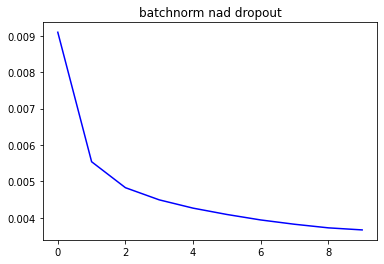

In [31]:
# Train models with batchnorm and dropout
nEpochs = 10

model = FashionModelTricks()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, weight_decay=0.001)
btrainer = Trainer(model, optimizer)
btrainer.run(nEpochs)
btrainer.saveModel('./dropoutBatchnormOptimizedModel.pt')
trainingPlot(btrainer.metrics, 'batchnorm nad dropout')
# trainingPlot(btrainer.metrics)

print('')

In [ ]:
# Gradient Clipping
# 'clip_grad_norm' helps pervent the exploding gradoent problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)

In [32]:
# Annealing Learning Rate
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epoch_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epoch_drop))
    return lrate